In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import logging
import os
import pickle
from pathlib import Path
from time import perf_counter

import numpy as np

from mcmc import MCMC
from mcmc.system import SurfaceSystem
from mcmc.utils import setup_logger
from mcmc.utils.misc import get_atoms_batch
from mcmc.utils.plot import plot_summary_stats

np.set_printoptions(precision=3, suppress=True)

Initialize pristine slab and parameters

In [3]:
# Initialize paths
surface_name = "SrTiO3(001)"
run_folder = Path() / surface_name
run_folder.mkdir(parents=True, exist_ok=True)

# Initialize logger
logger = setup_logger("mcmc", run_folder / "mc.log", logging.INFO)

# Load prepared pristine slab
try:
    with open("data/SrTiO3_001_2x2_pristine_slab.pkl", "rb") as f:
        slab = pickle.load(f)
except FileNotFoundError as e:
    print("Pristine surface pkl file not found. Please check you have downloaded the data.")
    raise e
offset_data_path = os.path.join(
    os.getcwd(),
    "data/nff",
    "offset_data.json",
)

try:
    with open(offset_data_path, "r") as f:
        offset_data = json.load(f)
except FileNotFoundError as e:
    print("Offset data file not found. Please check you have downloaded the data.")
    raise e

calc_settings = {
    "calc_name": "NFF",
    "optimizer": "BFGS",
    "chem_pots": {"Sr": -2, "Ti": 0, "O": 0},
    "relax_atoms": True,
    "relax_steps": 20,
    "offset": True,
    "offset_data": offset_data,
}

system_settings = {
    "surface_name": surface_name,
    "surface_depth": 1,
    "cutoff": 5.0,
    "near_reduce": 0.01,
    "planar_distance": 1.5,
    "no_obtuse_hollow": True,
    "ads_site_type": "all",
}

sampling_settings = {
    "total_sweeps": 10,
    "sweep_size": 5,
    "start_temp": 1.0,  # in terms of kbT
    "perform_annealing": False,
    "alpha": 1.0,  # no annealing
    "adsorbates": list(calc_settings["chem_pots"].keys()),
    "run_folder": run_folder,
}

Set up NFF Calculator. Here, we are using the same neural network weights from our Zenodo dataset (https://zenodo.org/record/7927039). The ensemble requires an `offset_data.json` file.

In [4]:
import torch
from nff.io.ase_calcs import NeuralFF
from nff.utils.cuda import cuda_devices_sorted_by_free_mem

from mcmc.calculators import EnsembleNFFSurface

DEVICE = f"cuda:{cuda_devices_sorted_by_free_mem()[-1]}" if torch.cuda.is_available() else "cpu"

# requires an ensemble of models in this path and an `offset_data.json` file
nnids = ["model01", "model02", "model03"]
model_dirs = [
    os.path.join(
        os.getcwd(),
        "data/nff",
        str(x),
        "best_model",
    )
    for x in nnids
]

models = []
for modeldir in model_dirs:
    m = NeuralFF.from_file(modeldir, device=DEVICE).model
    models.append(m)

nff_surf_calc = EnsembleNFFSurface(models, device=DEVICE)
nff_surf_calc.set(**calc_settings)

/home/dux/NeuralForceField/models


14:45:32 - mcmc.calculators | INFO: chemical potentials: {'Sr': -2, 'Ti': 0, 'O': 0} are set from parameters
14:45:32 - mcmc.calculators | INFO: offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters


offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters


{'calc_name': 'NFF',
 'optimizer': 'BFGS',
 'chem_pots': {'Sr': -2, 'Ti': 0, 'O': 0},
 'relax_atoms': True,
 'relax_steps': 20,
 'offset': True,
 'offset_data': {'bulk_energies': {'O': -0.17747231201,
   'Sr': -0.06043637668,
   'SrTiO3': -1.470008697358702},
  'stoidict': {'Sr': 0.49995161381315867,
   'Ti': -0.0637500349111578,
   'O': -0.31241304903276834,
   'offset': -11.324476454433157},
  'stoics': {'Sr': 1, 'Ti': 1, 'O': 3},
  'ref_formula': 'SrTiO3',
  'ref_element': 'Ti'}}

Initialize surface system

In [5]:
slab_batch = get_atoms_batch(
    slab,
    system_settings["cutoff"],
    DEVICE,
    props={"energy": 0, "energy_grad": []},
)

surface = SurfaceSystem(
    slab_batch,
    calc=nff_surf_calc,
    system_settings=system_settings,
    save_folder=run_folder,
)
surface.all_atoms.write(run_folder / "SrTiO3_001_2x2_all_virtual_ads.cif")

14:45:32 - mcmc.system | INFO: Initalizing adsorption sites with settings: {'surface_name': 'SrTiO3(001)', 'surface_depth': 1, 'cutoff': 5.0, 'near_reduce': 0.01, 'planar_distance': 1.5, 'no_obtuse_hollow': True, 'ads_site_type': 'all'}
14:45:32 - mcmc.system | INFO: Generated adsorption coordinates are: [array([ 7.871,  7.941, 18.82 ]), array([ 1.968,  1.951, 18.779]), array([ 1.968,  0.146, 18.732]), array([ 7.871,  3.956, 18.82 ]), array([ 1.968,  5.936, 18.779])]...
14:45:32 - mcmc.system | INFO: Initializing 64 virtual atoms
14:45:32 - mcmc.system | INFO: Initial state is [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
14:45:32 - mcmc.system | INFO: Number of pristine atoms is 60
14:45:32 - mcmc.system | INFO: Bulk indices are [ 0  1  2  3  4  5  6  9 10 11 12 13 14 15 16 17 18 19 20 21 24 25 26 27
 28 29 30 31 32 33 34 35 36 39 40 41 42 43 44 45 46 47 48 49 50 51 54 55
 56 57 58 59]
14:45:32 - mcmc

      Step     Time          Energy         fmax
BFGS:    0 14:45:33     -467.521881        0.2044
BFGS:    1 14:45:33     -467.525757        0.1803
BFGS:    2 14:45:33     -467.540619        0.0793
BFGS:    3 14:45:33     -467.540924        0.0598
BFGS:    4 14:45:33     -467.541351        0.0059


Calculate pristine surface energy

In [6]:
print(f"Surface energy {float(surface.get_surface_energy()):.3f} eV")

Surface energy 12.471 eV


Perform MCMC and view results. Detailed results can be found in the corresponding run in the `SrTiO3(001)/` folder.

In [7]:
mcmc = MCMC(**sampling_settings)

start = perf_counter()
results = mcmc.mcmc_run(
    surface=surface,
    **sampling_settings,
)
stop = perf_counter()
print(f"Time taken = {stop - start:.3f} seconds")

14:45:33 - mcmc.mcmc | INFO: Using run folder SrTiO3(001)
14:45:33 - mcmc.mcmc | INFO: There are 60 atoms in pristine slab
14:45:33 - mcmc.mcmc | INFO: Running with num_sweeps = 10, sweep_size = 5, start_temp = 1.000
14:45:33 - mcmc.mcmc | INFO: Starting with iteration 0
14:45:33 - mcmc.mcmc | INFO: Temperature schedule is: ['1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000']
14:45:33 - mcmc.mcmc | INFO: In sweep 1 out of 10


      Step     Time          Energy         fmax
BFGS:    0 14:45:34     -460.616699       29.2988
BFGS:    1 14:45:34     -465.137115       13.6841
BFGS:    2 14:45:34     -467.055756        6.2396
BFGS:    3 14:45:34     -467.966766        3.5717
BFGS:    4 14:45:34     -468.549164        1.4357
BFGS:    5 14:45:34     -468.697266        1.3260
BFGS:    6 14:45:34     -468.771027        1.4574
BFGS:    7 14:45:34     -468.952484        1.2846
BFGS:    8 14:45:34     -469.015411        0.6884
BFGS:    9 14:45:34     -469.034180        0.4729
BFGS:   10 14:45:34     -469.058258        0.5493
BFGS:   11 14:45:35     -469.076569        0.5428
BFGS:   12 14:45:35     -469.105316        0.5268
BFGS:   13 14:45:35     -469.131134        0.4527
BFGS:   14 14:45:35     -469.150635        0.4444
BFGS:   15 14:45:35     -469.162079        0.3970
BFGS:   16 14:45:35     -469.174316        0.3366
BFGS:   17 14:45:35     -469.185394        0.3896
BFGS:   18 14:45:35     -469.198883        0.4783
B

14:45:44 - mcmc.system | INFO: Optimized structure has Energy = 10.747
14:45:44 - mcmc.mcmc | INFO: In sweep 2 out of 10


      Step     Time          Energy         fmax
BFGS:    0 14:45:44     -456.894897       41.9946
BFGS:    1 14:45:44     -466.500763       16.1343
BFGS:    2 14:45:44     -470.534454        7.0789
BFGS:    3 14:45:44     -473.277802        3.7990
BFGS:    4 14:45:44     -474.623932        2.5493
BFGS:    5 14:45:45     -475.038177        2.2625
BFGS:    6 14:45:45     -475.451691        2.2206
BFGS:    7 14:45:45     -476.003998        2.5484
BFGS:    8 14:45:45     -476.472076        2.3728
BFGS:    9 14:45:45     -476.820709        1.6525
BFGS:   10 14:45:45     -476.992767        1.8524
BFGS:   11 14:45:45     -477.358124        1.9632
BFGS:   12 14:45:45     -477.744354        1.8499
BFGS:   13 14:45:45     -478.097656        2.0484
BFGS:   14 14:45:45     -478.468506        2.4571
BFGS:   15 14:45:46     -478.833618        2.8077
BFGS:   16 14:45:46     -479.180420        3.0118
BFGS:   17 14:45:46     -479.475830        3.1805
BFGS:   18 14:45:46     -479.825531        3.0518
B

14:45:54 - mcmc.system | INFO: Optimized structure has Energy = 10.845
14:45:54 - mcmc.mcmc | INFO: In sweep 3 out of 10


      Step     Time          Energy         fmax
BFGS:    0 14:45:55     -470.793945       47.2294
BFGS:    1 14:45:55     -480.156250       12.2076
BFGS:    2 14:45:55     -485.479126        8.8264
BFGS:    3 14:45:55     -488.556610        8.1546
BFGS:    4 14:45:55     -490.648651        6.0010
BFGS:    5 14:45:55     -491.301178        5.9589
BFGS:    6 14:45:55     -491.770905        2.3016
BFGS:    7 14:45:55     -492.430298        2.6285
BFGS:    8 14:45:55     -493.077545        3.5986
BFGS:    9 14:45:55     -493.408203        3.1186
BFGS:   10 14:45:55     -493.953583        1.4295
BFGS:   11 14:45:56     -494.075684        1.7823
BFGS:   12 14:45:56     -494.236053        2.0900
BFGS:   13 14:45:56     -494.621460        1.4909
BFGS:   14 14:45:56     -494.803345        1.3527
BFGS:   15 14:45:56     -495.115814        1.8447
BFGS:   16 14:45:56     -495.463135        2.9571
BFGS:   17 14:45:56     -495.757812        3.5359
BFGS:   18 14:45:56     -496.154510        2.8557
B

14:46:05 - mcmc.system | INFO: Optimized structure has Energy = 6.341
14:46:05 - mcmc.mcmc | INFO: In sweep 4 out of 10


      Step     Time          Energy         fmax
BFGS:    0 14:46:05     -467.654449       42.0832
BFGS:    1 14:46:05     -476.394043       12.9602
BFGS:    2 14:46:05     -481.145630        6.6810
BFGS:    3 14:46:05     -484.121826        3.8484
BFGS:    4 14:46:05     -485.665802        3.0198
BFGS:    5 14:46:05     -486.439209        2.8621
BFGS:    6 14:46:05     -487.249664        3.4808
BFGS:    7 14:46:05     -487.973602        4.1585
BFGS:    8 14:46:05     -488.719238        4.7263
BFGS:    9 14:46:06     -489.699799        4.2605
BFGS:   10 14:46:06     -490.671234        3.8801
BFGS:   11 14:46:06     -491.334106        2.5772
BFGS:   12 14:46:06     -491.963745        2.7341
BFGS:   13 14:46:06     -492.586700        2.4845
BFGS:   14 14:46:06     -493.166595        2.6039
BFGS:   15 14:46:06     -493.563324        2.7290
BFGS:   16 14:46:06     -493.904633        2.4355
BFGS:   17 14:46:06     -494.229614        1.6557
BFGS:   18 14:46:06     -494.460541        1.0941
B

14:46:15 - mcmc.system | INFO: Optimized structure has Energy = 7.101
14:46:15 - mcmc.mcmc | INFO: In sweep 5 out of 10


      Step     Time          Energy         fmax
BFGS:    0 14:46:15     -433.473145       96.1859
BFGS:    1 14:46:16     -456.843292       37.5973
BFGS:    2 14:46:16     -470.244141       28.8757
BFGS:    3 14:46:16     -481.222168       17.6464
BFGS:    4 14:46:16     -488.698090       10.8474
BFGS:    5 14:46:16     -492.730377        6.5296
BFGS:    6 14:46:16     -495.178680        4.7365
BFGS:    7 14:46:16     -496.984863        4.1099
BFGS:    8 14:46:16     -498.330048        4.1794
BFGS:    9 14:46:16     -499.758270        5.2587
BFGS:   10 14:46:16     -501.079559        4.1712
BFGS:   11 14:46:16     -502.558228        4.5334
BFGS:   12 14:46:17     -504.131989        2.8642
BFGS:   13 14:46:17     -505.022064        2.6019
BFGS:   14 14:46:17     -505.801758        2.7016
BFGS:   15 14:46:17     -506.620239        2.7086
BFGS:   16 14:46:17     -507.501709        2.7070
BFGS:   17 14:46:17     -508.132172        1.8959
BFGS:   18 14:46:17     -508.459076        1.2227
B

14:46:26 - mcmc.system | INFO: Optimized structure has Energy = 1.397
14:46:26 - mcmc.mcmc | INFO: In sweep 6 out of 10


      Step     Time          Energy         fmax
BFGS:    0 14:46:26     -371.918335      136.6040
BFGS:    1 14:46:26     -432.883667       59.9277
BFGS:    2 14:46:26     -453.724030       44.9304
BFGS:    3 14:46:26     -467.328766       35.2514
BFGS:    4 14:46:26     -481.542725       19.0972
BFGS:    5 14:46:27     -489.489532       11.7901
BFGS:    6 14:46:27     -494.151123        7.8249
BFGS:    7 14:46:27     -496.534912        4.3790
BFGS:    8 14:46:27     -498.383911        3.8234
BFGS:    9 14:46:27     -500.184082        3.9300
BFGS:   10 14:46:27     -501.667694        4.9853
BFGS:   11 14:46:27     -503.137970        3.4550
BFGS:   12 14:46:27     -504.145996        2.9128
BFGS:   13 14:46:27     -504.753021        2.9108
BFGS:   14 14:46:28     -505.401825        2.8717
BFGS:   15 14:46:28     -505.875122        2.4266
BFGS:   16 14:46:28     -506.399139        1.6298
BFGS:   17 14:46:28     -506.619873        1.6347
BFGS:   18 14:46:28     -506.887299        1.3038
B

14:46:37 - mcmc.system | INFO: Optimized structure has Energy = 1.397
14:46:37 - mcmc.mcmc | INFO: In sweep 7 out of 10


      Step     Time          Energy         fmax
BFGS:    0 14:46:37     -376.603790      148.1767
BFGS:    1 14:46:37     -420.464813       78.6861
BFGS:    2 14:46:37     -445.028778       56.9429
BFGS:    3 14:46:38     -463.872162       32.0599
BFGS:    4 14:46:38     -476.104614       27.1339
BFGS:    5 14:46:38     -485.950409       16.1225
BFGS:    6 14:46:38     -491.984406        8.9537
BFGS:    7 14:46:38     -495.750031        6.2970
BFGS:    8 14:46:38     -498.258453        5.6187
BFGS:    9 14:46:38     -500.168091        4.8690
BFGS:   10 14:46:38     -501.629791        4.4513
BFGS:   11 14:46:38     -503.420868        5.4235
BFGS:   12 14:46:38     -505.241821        3.6486
BFGS:   13 14:46:39     -506.775726        3.0275
BFGS:   14 14:46:39     -507.378632        4.2357
BFGS:   15 14:46:39     -507.994873        2.6940
BFGS:   16 14:46:39     -508.657318        2.3066
BFGS:   17 14:46:39     -509.559967        2.7090
BFGS:   18 14:46:39     -510.312622        3.0008
B

14:46:49 - mcmc.system | INFO: Optimized structure has Energy = 2.154
14:46:49 - mcmc.mcmc | INFO: In sweep 8 out of 10


      Step     Time          Energy         fmax
BFGS:    0 14:46:49     -435.835907       95.5563
BFGS:    1 14:46:49     -461.500153       38.2612
BFGS:    2 14:46:49     -475.340332       23.7958
BFGS:    3 14:46:49     -487.253754       16.1074
BFGS:    4 14:46:49     -495.695557       12.0843
BFGS:    5 14:46:49     -500.865631        7.4874
BFGS:    6 14:46:49     -504.134399        5.2879
BFGS:    7 14:46:49     -506.396393        4.4797
BFGS:    8 14:46:49     -508.118652        3.7106
BFGS:    9 14:46:50     -508.891266        6.0173
BFGS:   10 14:46:50     -509.785645        3.5087
BFGS:   11 14:46:50     -511.361572        2.4511
BFGS:   12 14:46:50     -512.191345        4.7213
BFGS:   13 14:46:50     -512.695068        4.0510
BFGS:   14 14:46:50     -513.668518        3.2287
BFGS:   15 14:46:50     -514.139465        2.2394
BFGS:   16 14:46:50     -514.747803        2.5256
BFGS:   17 14:46:50     -515.496155        2.3307
BFGS:   18 14:46:50     -515.854492        2.3159
B

14:46:59 - mcmc.system | INFO: Optimized structure has Energy = 3.072
14:46:59 - mcmc.mcmc | INFO: In sweep 9 out of 10


      Step     Time          Energy         fmax
BFGS:    0 14:46:59     -445.715302       96.9700
BFGS:    1 14:47:00     -464.626007       36.5737
BFGS:    2 14:47:00     -476.515350       26.2116
BFGS:    3 14:47:00     -486.033173       17.1969
BFGS:    4 14:47:00     -492.769775       10.4578
BFGS:    5 14:47:00     -497.012848        5.8558
BFGS:    6 14:47:00     -499.021759        6.9056
BFGS:    7 14:47:00     -500.256500        4.1911
BFGS:    8 14:47:00     -501.634399        3.4758
BFGS:    9 14:47:00     -502.637299        3.5196
BFGS:   10 14:47:00     -503.730682        3.7551
BFGS:   11 14:47:01     -504.508392        3.7301
BFGS:   12 14:47:01     -505.221924        2.7063
BFGS:   13 14:47:01     -505.632324        3.2807
BFGS:   14 14:47:01     -505.902954        2.2699
BFGS:   15 14:47:01     -506.313721        1.4942
BFGS:   16 14:47:01     -506.451569        1.3352
BFGS:   17 14:47:01     -506.659180        1.5096
BFGS:   18 14:47:01     -506.783081        1.4236
B

14:47:10 - mcmc.system | INFO: Optimized structure has Energy = 2.890
14:47:10 - mcmc.mcmc | INFO: In sweep 10 out of 10


      Step     Time          Energy         fmax
BFGS:    0 14:47:10       96.329414     9122.1958
BFGS:    1 14:47:10     -430.911285       84.4665
BFGS:    2 14:47:10     -455.784149       37.9478
BFGS:    3 14:47:11     -470.624115       21.0235
BFGS:    4 14:47:11     -484.307159       14.1571
BFGS:    5 14:47:11     -493.810699       10.7430
BFGS:    6 14:47:11     -499.828979       13.9527
BFGS:    7 14:47:11     -503.549103       12.1151
BFGS:    8 14:47:11     -505.990936        7.3813
BFGS:    9 14:47:11     -507.985748        4.0791
BFGS:   10 14:47:11     -510.371246       28.1456
BFGS:   11 14:47:11     -512.067810       36.9496
BFGS:   12 14:47:12     -518.333008       22.9171
BFGS:   13 14:47:12     -521.214355        4.4173
BFGS:   14 14:47:12     -522.743591        2.6534
BFGS:   15 14:47:12     -523.526428        2.9052
BFGS:   16 14:47:12     -524.786072        3.4852
BFGS:   17 14:47:12     -525.352539        3.6997
BFGS:   18 14:47:12     -526.229187        2.9707
B

14:47:22 - mcmc.system | INFO: Optimized structure has Energy = -0.892


Time taken = 109.067 seconds


Plot results

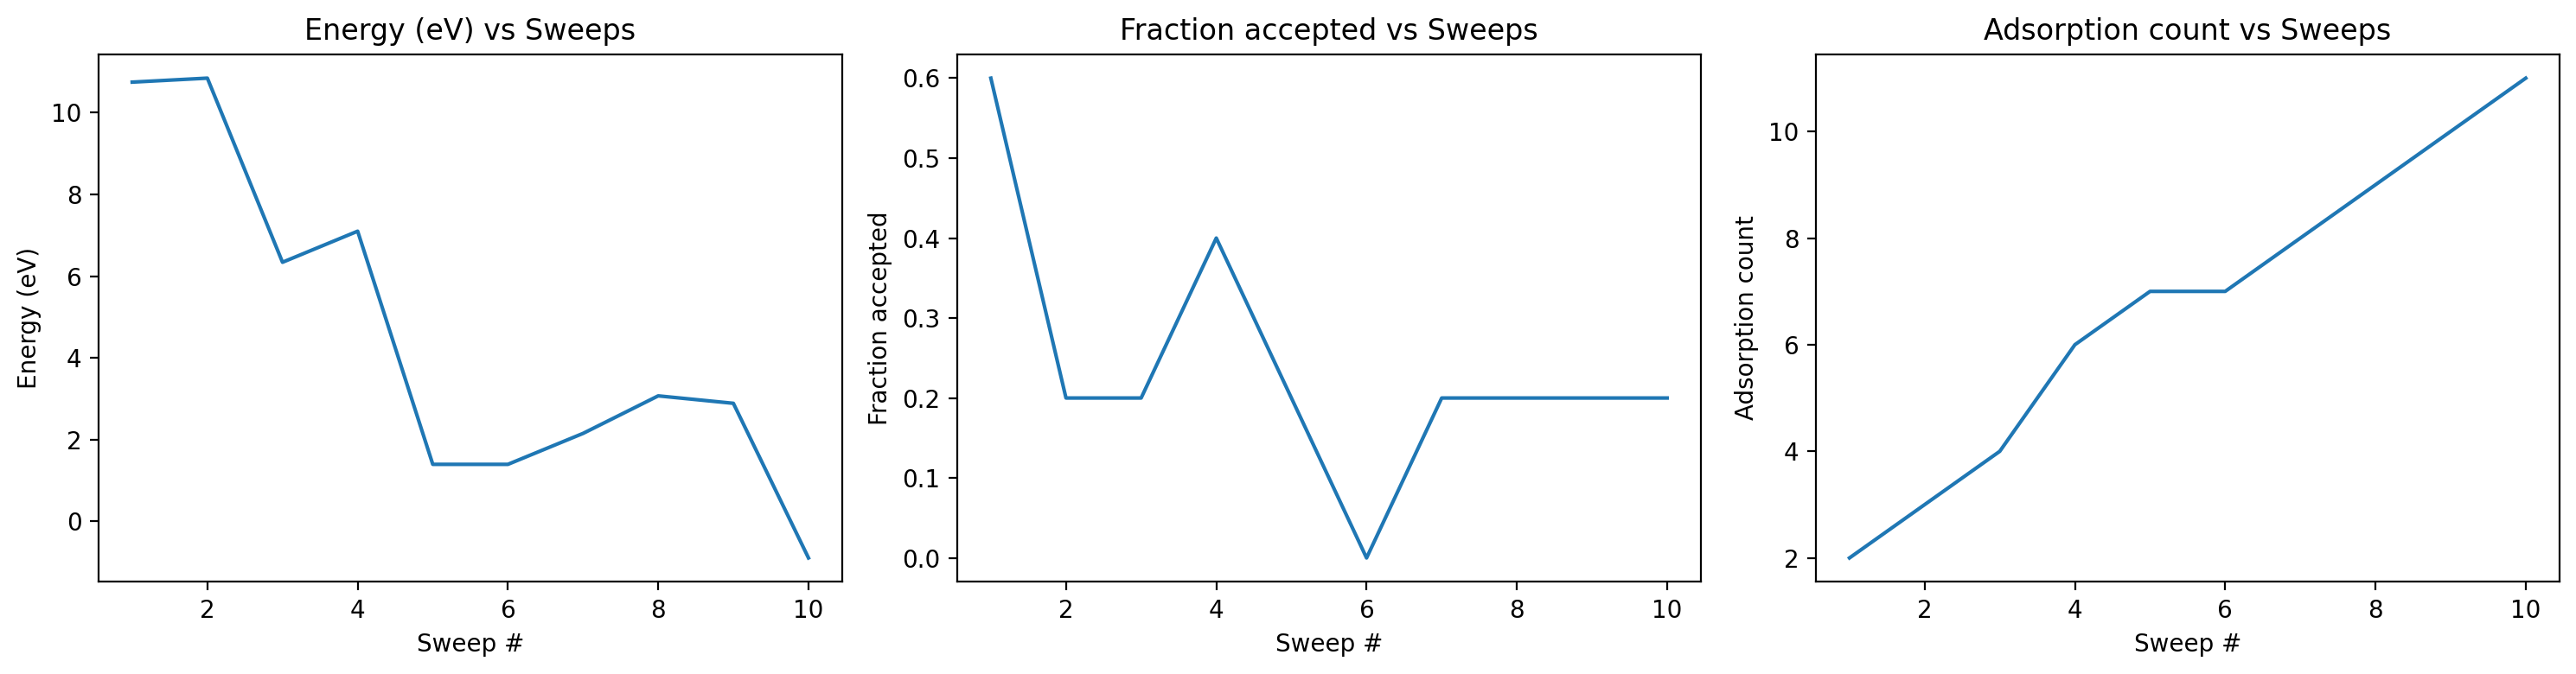

In [8]:
fig = plot_summary_stats(
    results["energy_hist"],
    results["frac_accept_hist"],
    results["adsorption_count_hist"],
    sampling_settings["total_sweeps"],
    save_folder=run_folder,
)

Save structures for later use in latent space clustering or analysis

In [9]:
structures = results["history"]
with open("data/SrTiO3_001_2x2_mcmc_structures.pkl", "wb") as f:
    pickle.dump(structures, f)